<a href="https://colab.research.google.com/github/jetsonai/HK_LSTMSenfuClass/blob/main/Day1/CNN/%5B1%5DVGG_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGGNet Inference Test (RGB, CIFAR-10)
## TensorFlow/Keras version

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 모델 정의 (훈련 때와 동일 구조)

In [17]:
IMG_SIZE = 32
NUM_CLASSES = 10

In [18]:
# CIFAR-10 클래스 이름
CLASS_NAMES = [
    "airplane",   # 0
    "automobile", # 1
    "bird",       # 2
    "cat",        # 3
    "deer",       # 4
    "dog",        # 5
    "frog",       # 6
    "horse",      # 7
    "ship",       # 8
    "truck"       # 9
]


In [19]:
WIDTH = 16
USE_BN_DROPOUT = False
P_DROPOUT = 0.25

In [20]:
# CIFAR-10 mean/std in RGB order (same as PyTorch version)
CIFAR10_MEAN = np.array([0.4914, 0.4822, 0.4465], dtype=np.float32)
CIFAR10_STD  = np.array([0.2470, 0.2435, 0.2616], dtype=np.float32)

In [21]:
from tensorflow.keras import layers, models

def ConvBlock(x, out_ch, num_layers=2, use_bn=False):
    for _ in range(num_layers):
        x = layers.Conv2D(out_ch, kernel_size=3, strides=1, padding="same",
                          use_bias=not use_bn, kernel_initializer="he_normal")(x)
        if use_bn:
            x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    return x

def LinearBlock(x, out_dim, p_drop=0.0, use_dropout=False):
    x = layers.Dense(x.shape[-1], kernel_initializer="he_normal")(x)
    if use_dropout:
        x = layers.Dropout(p_drop)(x)
    x = layers.ReLU()(x)

    x = layers.Dense(x.shape[-1], kernel_initializer="he_normal")(x)
    if use_dropout:
        x = layers.Dropout(p_drop)(x)
    x = layers.ReLU()(x)

    x = layers.Dense(out_dim)(x)  # from_logits=True로 학습했으므로 softmax 없음
    return x

def build_vgg16(img_channels=3, width=16, num_classes=10, use_bn_dropout=False, p=0.25):
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, img_channels))
    x = ConvBlock(inp, width,   num_layers=2, use_bn=use_bn_dropout); x = layers.MaxPool2D(2)(x)
    x = ConvBlock(x,   width*2, num_layers=2, use_bn=use_bn_dropout); x = layers.MaxPool2D(2)(x)
    x = ConvBlock(x,   width*4, num_layers=3, use_bn=use_bn_dropout); x = layers.MaxPool2D(2)(x)
    x = ConvBlock(x,   width*4, num_layers=3, use_bn=use_bn_dropout); x = layers.MaxPool2D(2)(x)
    x = ConvBlock(x,   width*4, num_layers=3, use_bn=use_bn_dropout); x = layers.MaxPool2D(2)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = LinearBlock(x, num_classes, p_drop=p, use_dropout=use_bn_dropout)
    return models.Model(inp, x, name="VGG16_TF" + ("_BN" if use_bn_dropout else ""))


# 정규화 + 시각화 추론 함수 (inference_visualize)

In [22]:
def _normalize_inference(x):
    # x: float32 [0,1], shape (..., 3)
    return (x - CIFAR10_MEAN) / CIFAR10_STD

def inference_visualize(
    weights_path:str,
    num_samples:int = 5,
    seed:int | None = None,
    width:int = WIDTH,
    use_bn_dropout:bool = USE_BN_DROPOUT,
    p_dropout:float = P_DROPOUT,
):
    # 1) CIFAR-10 테스트셋
    (_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_test = y_test.squeeze()
    x_test_f32 = x_test.astype(np.float32) / 255.0  # [0,1]

    # 2) 모델 빌드 & 가중치 로드 (훈련 설정과 동일해야 함)
    model = build_vgg16(
        img_channels=3,
        width=width,
        num_classes=NUM_CLASSES,
        use_bn_dropout=use_bn_dropout,
        p=p_dropout
    )
    model.load_weights(weights_path)
    print(f"✅ Loaded weights: {weights_path}")

    # 3) 무작위 샘플 선택
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(x_test), size=num_samples, replace=False)

    # 4) 입력 준비
    imgs_vis = x_test[idxs]                          # 시각화용 (uint8)
    imgs_in  = _normalize_inference(x_test_f32[idxs])  # 추론용 (정규화)

    # 5) 예측 (logits → softmax 확률)
    logits = model.predict(imgs_in, verbose=0)
    probs  = tf.nn.softmax(logits, axis=1).numpy()
    preds  = probs.argmax(axis=1)

    # 6) 시각화
    for i, (img_u8, prob, pred, gt) in enumerate(zip(imgs_vis, probs, preds, y_test[idxs])):
        plt.figure(figsize=(10, 4))

        # (좌) 이미지
        plt.subplot(1, 2, 1)
        plt.imshow(img_u8)
        plt.title(f"[{i}] GT: {CLASS_NAMES[gt]}\nPred: {CLASS_NAMES[pred]} ({prob[pred]*100:.2f}%)")
        plt.axis("off")

        # (우) 확률 막대그래프
        plt.subplot(1, 2, 2)
        bars = plt.bar(range(10), prob)
        plt.xticks(range(10), CLASS_NAMES, rotation=45, ha='right')
        plt.ylabel("Probability"); plt.ylim(0, 1)
        bars[pred].set_color("orange")
        plt.title("Prediction Probabilities")

        plt.tight_layout(); plt.show()
        print(f"[{i}] Pred={CLASS_NAMES[pred]}  GT={CLASS_NAMES[gt]}")
        print("probs:", np.round(prob, 3))

    return {"indices": idxs, "preds": preds, "gts": y_test[idxs], "probs": probs}


# 실행: 업로드한 가중치로 추론/시각화

In [23]:
!ls /content/

sample_data  vgg16_rgb_final.weights.h5


In [24]:
WEIGHTS_PATH = 'vgg16_rgb_final.weights.h5'

✅ Loaded weights: vgg16_rgb_final.weights.h5


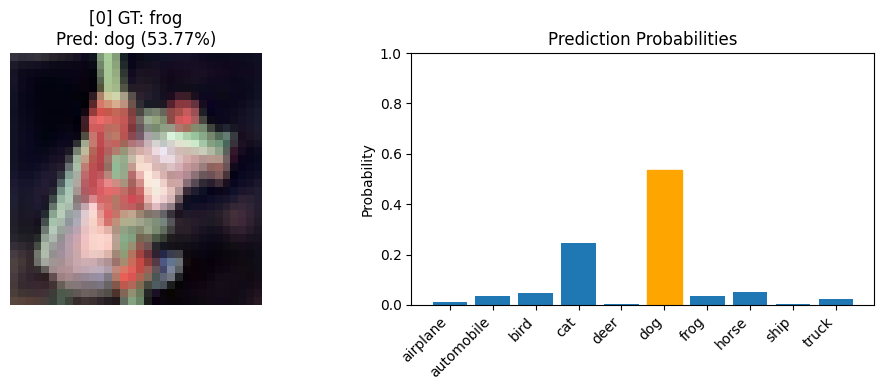

[0] Pred=dog  GT=frog
probs: [0.013 0.037 0.047 0.247 0.004 0.538 0.036 0.053 0.004 0.022]


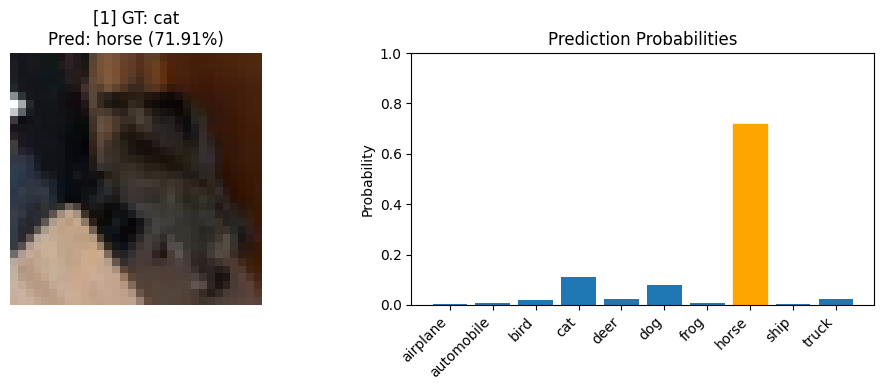

[1] Pred=horse  GT=cat
probs: [0.005 0.006 0.021 0.112 0.023 0.079 0.009 0.719 0.002 0.023]


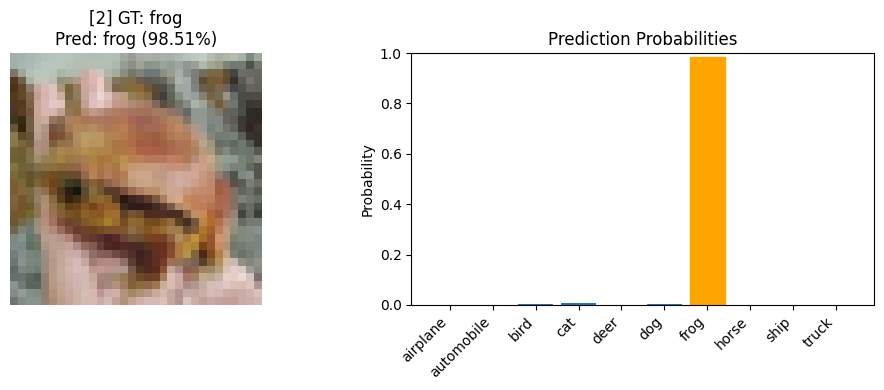

[2] Pred=frog  GT=frog
probs: [0.    0.    0.004 0.008 0.001 0.002 0.985 0.    0.    0.   ]


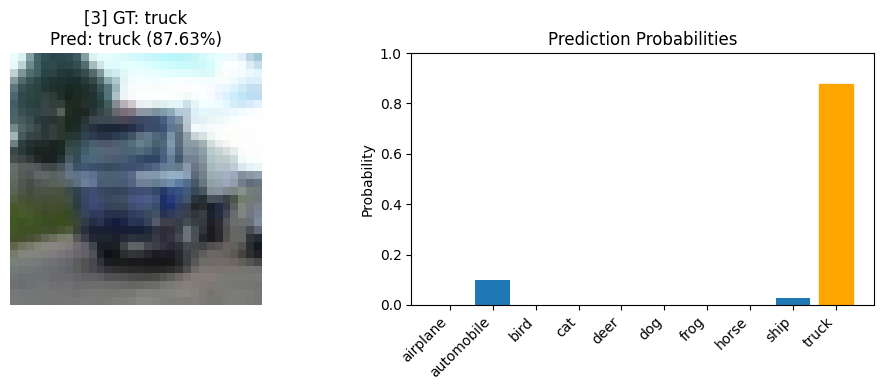

[3] Pred=truck  GT=truck
probs: [0.001 0.097 0.    0.    0.    0.    0.    0.    0.026 0.876]


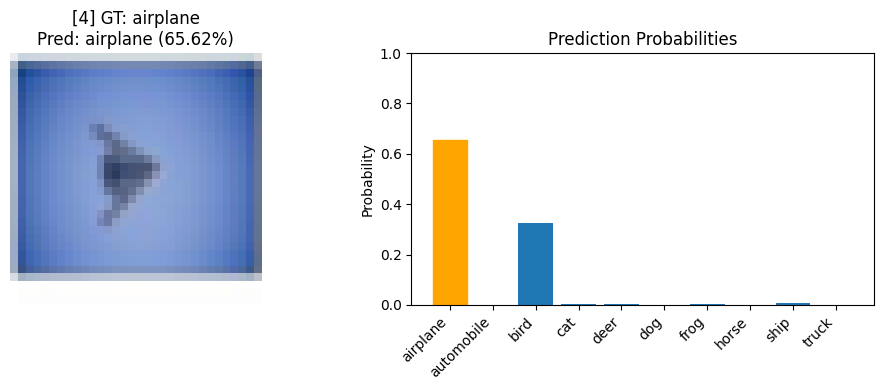

[4] Pred=airplane  GT=airplane
probs: [0.656 0.    0.325 0.003 0.003 0.    0.002 0.    0.009 0.   ]


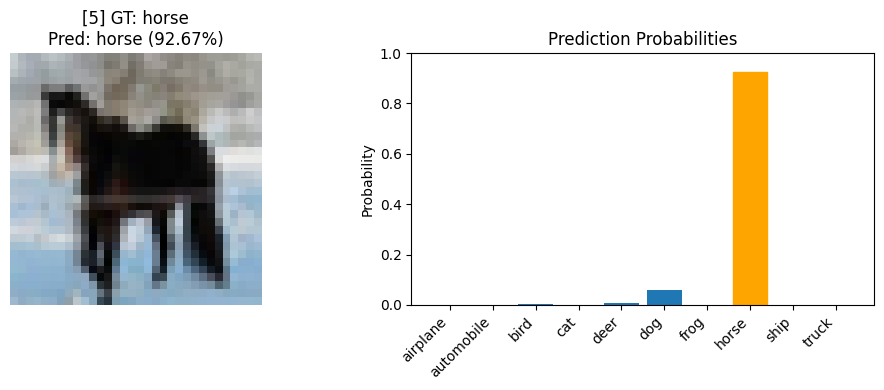

[5] Pred=horse  GT=horse
probs: [0.    0.    0.004 0.001 0.007 0.06  0.    0.927 0.    0.   ]


In [25]:
out = inference_visualize(
    weights_path=WEIGHTS_PATH,  # 업로드한 파일 경로
    num_samples=6,
    seed=42,
    width=WIDTH,
    use_bn_dropout=USE_BN_DROPOUT,
    p_dropout=P_DROPOUT
)
